In [135]:
########################
#author: 최푸름
#date: 2021. 01. 12
#describe: 주식크롤링
########################

import pandas as pd 
import requests
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Activation
from bs4 import BeautifulSoup
import os 
from datetime import datetime
import matplotlib.pyplot as plt
# 필요한 모듈 import 하기 
import plotly
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline 

#해당 링크는 한국거래소에서 상장법인목록을 엑셀로 다운로드하는 링크
#다운로드와 동시에 Pandas에 excel 파일이 load가 되는 구조
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0] 
#stock_code.head()
# 데이터에서 정렬이 따로 필요하지는 않지만 테스트겸 Pandas sort_values를 이용하여 정렬을 시도해봅니다.
code_df.sort_values(['상장일'], ascending=True)

# 필요한 것은 "회사명"과 "종목코드" 이므로 필요없는 column들은 제외
code_df = code_df[['회사명', '종목코드']] 

# 한글 컬럼명을 영어로 변경 
code_df = code_df.rename(columns={'회사명': 'company', '종목코드': 'code'}) 
#stock_code.head()

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.code = code_df.code.map('{:06d}'.format) 
code_df.head()

,company,code
0,JS전선,005560
1,거북선2호,101380
2,거북선6호,114140
3,교보메리츠,064900
4,국제관광공사,028780


In [101]:
def price(code):
    # code_n = code(name)
    url="https://finance.naver.com/item/sise_day.nhn"
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36'}
    
    result = pd.DataFrame()
    
    for num in range(1,396):
        price_list = []
        
        params ={
            'code':code,
            'page': '{}'.format(num)           
        }
        resp = requests.get(url,params=params, headers=headers)
        soup = BeautifulSoup(resp.content, 'html.parser')
        for tr in soup.find_all('tr')[2:15]:
            new_dict = {}
            td_list = tr.find_all('td')
            if not td_list[0].text.strip():
                continue
            tdtext_list =['날짜','종가','전일비','시가','고가','저가','거래량']
            
            for i in range(7):
                new_dict[tdtext_list[i]] = td_list[i].text.replace(',','').strip()
            price_list.append(new_dict)
            df_price = pd.DataFrame(price_list, columns =['날짜','종가','전일비','시가','고가','저가','거래량'])
            result= result.append(df_price)   
               
    return result

In [102]:
price('052220')

,날짜,종가,전일비,시가,고가,저가,거래량
0,2021.01.12,6840,290,6420,6940,6320,1867811
0,2021.01.12,6840,290,6420,6940,6320,1867811
1,2021.01.11,6550,270,6700,7010,6050,2831695
0,2021.01.12,6840,290,6420,6940,6320,1867811
1,2021.01.11,6550,270,6700,7010,6050,2831695
...,...,...,...,...,...,...,...
5,2005.01.27,11900,1250,11900,11900,11900,129833
6,2005.01.26,10650,1110,10650,10650,10650,194211
7,2005.01.25,9540,1020,9540,9540,9540,304440
8,2005.01.24,8520,910,8520,8520,8520,10980


In [103]:
df=price('052220')
# df.dropna()를 이용해 결측값 있는 행 제거 
df = df.dropna() 

# 한글로 된 컬럼명을 영어로 바꿔줌 
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
# 데이터의 타입을 int형으로 바꿔줌 
df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 

# 컬럼명 'date'의 타입을 date로 바꿔줌 
df['date'] = pd.to_datetime(df['date']) 

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True) 

# 상위 5개 데이터 확인 
df.head()

,date,close,diff,open,high,low,volume
9,2005-01-21,7610,4210,6800,7610,6800,51349
8,2005-01-24,8520,910,8520,8520,8520,10980
8,2005-01-24,8520,910,8520,8520,8520,10980
7,2005-01-25,9540,1020,9540,9540,9540,304440
7,2005-01-25,9540,1020,9540,9540,9540,304440


In [24]:
def save(name):
    while True:
        new_name = name.upper()
        c_data = code_df[code_df['company'].isin([new_name])]
        if c_data.size ==0:
            print('정확한 회사명을 입력하세요')
            company_ex = code_df[code_df.company.str.contains(new_name)==True]
            print(company_ex)
            name= input('회사이름을 적어주세요: ')
            continue
        code = c_data['code'].values[0]
        new_code = '%06d' %code
        break

In [104]:
import os
from datetime import datetime

name = 'imbc'
new_code = '052220'

df_price = df
BASE_DIR = os.getcwd()
SAVE_DB_DIR = os.path.join(BASE_DIR, name)

if not os.path.exists(SAVE_DB_DIR):
    os.makedirs(SAVE_DB_DIR)
    temp_name = f"{name}_{new_code}_{datetime.today().year}.xlsx"
    txt_name =os.path.join(SAVE_DB_DIR, temp_name)
    print(txt_name)
    excel_writer = pd.ExcelWriter(txt_name, engine='xlsxwriter')
    df_price.to_excel(excel_writer, sheet_name='price')
    excel_writer.save()
    print("저장완료. 프로그램 종료")
    
else:
    temp_name = f"{name}_{new_code}_{datetime.today().year}.xlsx"
    txt_name =os.path.join(SAVE_DB_DIR, temp_name)
    print(txt_name)
    excel_writer = pd.ExcelWriter(txt_name, engine='xlsxwriter')
    df_price.to_excel(excel_writer, sheet_name='price')
    excel_writer.save()
    print("저장완료. 프로그램 종료")

C:\Users\User\imbc\imbc_052220_2021.xlsx
저장완료. 프로그램 종료


In [ ]:
## 출력 그래프

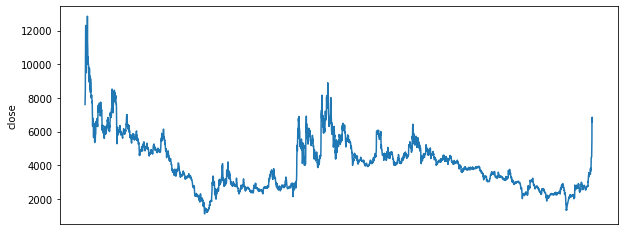

In [105]:

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'])
plt.xlabel('')
plt.ylabel('close')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('iMBC' + ".png")
plt.show()

In [106]:
fig = px.line(df, x='date', y='close', title='{}의 종가(close) Time Series'.format('iMBC'))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
### 학습

In [129]:
#Compute Mid Price

high_prices = df['high'].values
low_prices = df['low'].values
mid_prices = (high_prices+low_prices)/2

print(mid_prices)

[7205. 8520. 8520. ... 6630. 6630. 6630.]


In [132]:
#Create Windows

seq_len = 100
sequence_length = seq_len+1

result =[]
for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index: index+sequence_length])

In [133]:
#Normalize Data

normalized_data =[]
for window in result:
    normalized_window =[((float(p)/float(window[0]))-1)for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

#split train and test data
row= int(round(result.shape[0]*0.9))
train = result[:row,:]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_test = result[row:,-1]

x_train.shape,x_test.shape

((19462, 100, 1), (2162, 100, 1))

In [136]:
#Build a Model

model = Sequential() #모델을 순차적으로 
model.add(LSTM(50, return_sequences =True, input_shape=(50,1))) #
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1,activation='linear')) #선형회귀방식

model.compile(loss='mse',optimizer='rmsprop')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [142]:
# Training

model.fit(x_train, y_train, 
          validation_data=(x_test,y_test), #
          batch_size=10, 
          epochs=1)

1947/1947 [==============================] - 76s 39ms/step - loss: 2.1980e-04 - val_loss: 2.8017e-04


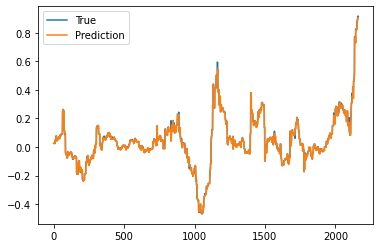

In [143]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test,label='True')
ax.plot(pred, label ='Prediction')
ax.legend()
plt.show()